In [364]:
import os
import cv2 as cv
import PIL
import numpy as np
import matplotlib.pyplot as plt
import re
plt.rcParams["figure.figsize"] = (30,30)

# Lo primero que hemos de hacer es automatizar el proceso de recortar en cuadrados las imágenes de heridas y de los tejidos sanos de la misma imagen.

def cut(path_load, name):
    import numpy as np
    import cv2 as cv

    img = cv.imread(path_load+"/"+name)

    # Guardamos las dimensiones de la imagen
    dims = (img.shape[0], img.shape[1])

    # Vamos a realizar una suma en los 3 canales RBG, por lo que tendremos un array de Width x Height.
    img_sum = np.sum(img, axis = 2)

    # Ahora trataremos de encontrar el píxel mínimo y máximo en cada dimensión diferente de cero.
    indexs = [[],[]]

    [indexs[0], indexs[1]] = [[np.where(img_sum[i,:]>0) for i in range(dims[0])], [np.where(img_sum[:,i]>0) for i in range(dims[1])]]

    # En indexs[0] tenemos 480 arrays con los indices de los píxeles que son mayores de cero para la primera dimensión. De forma análoga para indexs[1].

    min_x = [indexs[1][i][0][0] if len(indexs[1][i][0] > 0) else -1 for i in range(len(indexs[1]))]
    max_x = [indexs[1][i][0][len(indexs[1][i][0])-1] if len(indexs[1][i][0] > 0) else -1 for i in range(len(indexs[1]))]

    min_x = np.min(list(filter(lambda number: number > 0, min_x)))
    max_x = np.max(list(filter(lambda number: number > 0, max_x)))

    limits_x = (min_x, max_x)

    min_y = [indexs[0][i][0][0] if len(indexs[0][i][0] > 0) else -1 for i in range(len(indexs[0]))]
    max_y = [indexs[0][i][0][len(indexs[0][i][0])-1] if len(indexs[0][i][0] > 0) else -1 for i in range(len(indexs[0]))]

    min_y = np.min(list(filter(lambda number: number > 0, min_y)))
    max_y = np.max(list(filter(lambda number: number > 0, max_y)))

    limits_y = (min_y, max_y)

    new_dims = np.max([limits_x[1]-limits_x[0], limits_y[1]-limits_y[0]])

    # Ahora hemos de recortar la imagen.

    new_limits = [(limits_x[0],limits_y[0]),(limits_x[0]+new_dims, limits_y[0]+new_dims)]

    img_new = img[new_limits[0][0]:new_limits[1][0],new_limits[0][1]:new_limits[1][1],:]

    # Si la imagen no es un cuadrado la rellenaremos con píxeles en negro.

    if img_new.shape[0] != img_new.shape[1]:
        index_min = np.where(np.array([img_new.shape[0], img_new.shape[1]]) == np.min(np.array([img_new.shape[0], img_new.shape[1]])))[0][0]
        if index_min == 0:
            zeros = np.zeros((img_new.shape[1]-img_new.shape[0],img_new.shape[1],3))
            new_img = np.vstack((zeros, img_new))
            return new_img
        else:
            zeros = np.zeros((img_new.shape[0],img_new.shape[0]-img_new.shape[1],3))
            new_img = np.hstack((zeros, img_new))
            return new_img
    else:
        return img_new

In [365]:
# Función de preprocesado: normalización de 0-255 a 0-1 y posterior estandarización de los 3 canales RGB independientemente.
# Para realizar la estandarización hemos de usar la media y la std de las imágenes de tejido sano correspondientes a cada una de las heridas orales.
# Devuelve una imagen.

def preprocessing(path_inj, path_healthy, name_img, format):
    import numpy as np
    import cv2 as cv

    img_inj = cv.imread(path_inj+"/"+name_img+"."+format)
    img_healthy = cv.imread(path_healthy+"/"+name_img+"."+format)

    def standardize(img1, img2):
        mean = np.mean(img1)
        std = np.std(img1)
        img = (img2-mean)/std
        return img

    r_channel = standardize(img_healthy[:,:,0], img_inj[:,:,0])
    g_channel = standardize(img_healthy[:,:,1], img_inj[:,:,1])
    b_channel = standardize(img_healthy[:,:,2], img_inj[:,:,2])

    # Para evitar valores negativos en las imágenes de salida, aplicaremos la "unity-based normalization" tras estandarizar los canales.

    image_std = np.stack([r_channel, g_channel, b_channel], axis=-1)
    image_std_normalized = (image_std-np.min(image_std))/(np.max(image_std)-np.min(image_std))

    return image_std_normalized

In [366]:
# Función de redimensión de una imagen a otro tamaño destino. Toma como entrada una imagen y las dimensiones deseadas.
# Como entrada también toma el tipo de interpolación deseada para redimensionar la imagne.
# Devuelve una imagen.

def resize(img, X, Y, method = "linear"):
    import cv2 as cv
    if method == "linear":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_LINEAR)
    elif method == "nearest":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_NEAREST)
    elif method == "area":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_AREA)
    elif method == "cubic":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_CUBIC)
    elif method == "lanczos4":
        res = cv.resize(img, (X,Y), interpolation=cv.INTER_LANCZOS4)
    else:
        print("Please choose one of the available interpolation methods: 'linear', 'nearest', 'area', 'cubic' or 'lanczos4'. Linear interpolation works by default.")
    
    return res

In [367]:
# Ahora haremos Data Augmentation

# Si queremos hacer Data Augmentation, tendremos que cargar las imágenes sin estandarizar, únicamente recortadas.

import cv2 as cv

files = os.listdir("Heridas/Recortados")
images = [cv.imread("Heridas/Recortados/"+str(i+1)+".png") for i in range(len(files))]
sizes = [cv.imread("Heridas/Recortados/"+str(i+1)+".png").shape[0] for i in range(len(files))]

# Ya tenemos una lista de las imágenes, ahora haremos Data Augmentation.

# Data Augmentation, consideramos añadir 6 imágenes por cada una de las que tenemos.

In [368]:
# Ahora haremos algo de DataAugmentation para conseguir algunas imágenes extra.

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Consideraremos, como primera medida, obtener 4 imágenes modificadas, aleatoriamente, de cada una de las que tenemos realizando diferentes operaciones como
# traslaciones, rotaciones, zooms, ...
# Crearemos una nueva función de preprocesado específica para este caso.

def preprocessing_dataug(path_inj, path_healthy, name_img, img):
    import numpy as np
    import cv2 as cv

    img_inj = img
    img_healthy = cv.imread(path_healthy+"/"+name_img+".png")

    def standardize(img1, img2):
        mean = np.mean(img1)
        std = np.std(img1)
        img = (img2-mean)/std
        return img

    r_channel = standardize(img_healthy[:,:,0], img_inj[:,:,0])
    g_channel = standardize(img_healthy[:,:,1], img_inj[:,:,1])
    b_channel = standardize(img_healthy[:,:,2], img_inj[:,:,2])

    # Para evitar valores negativos en las imágenes de salida, aplicaremos la "unity-based normalization" tras estandarizar los canales.

    image_std = np.stack([r_channel, g_channel, b_channel], axis=-1)
    image_std_normalized = (image_std-np.min(image_std))/(np.max(image_std)-np.min(image_std))

    return image_std_normalized

In [369]:
new_images = []
num_new_images = 10

for i in range(len(images)):

    dim_img = images[i].shape[0]
    samples = expand_dims(images[1], 0)
    datagen = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, vertical_flip = True, rotation_range = 45)
    it = datagen.flow(samples, batch_size = 1)

    for j in range(num_new_images):
        batch = it.next()
        image = batch[0].astype('uint8')
        image_new = preprocessing_dataug("Heridas/Recortados", "Sanos/Recortados", str(i+1), image)
        new_images.append(image_new)

In [370]:
# Ahora hemos de preprocesar también las imágenes originales y luego concatenar ambas listas (la original y la creada)

for i in range(len(files)):
    images[i] = preprocessing_dataug("Heridas/Recortados", "Sanos/Recortados", str(i+1), images[i])

data_augmented = images+new_images

In [371]:
# Ahora haremos un resize y las dispondremos en un array.

new_dim = int(round(np.mean(sizes)))

new_data_augmented = [resize(data_augmented[i], X = new_dim, Y = new_dim, method = "linear") for i in range(len(data_augmented))]

new_data_augmented = np.stack(new_data_augmented, axis = 0)

# Extracción de las etiquetas y la histología

In [372]:
# Ahora hemos de sacar las etiquetas del CSV.

import pandas as pd

data = pd.read_csv("Leucoplasia307.csv")

labels = np.array(data["Evolucioncancer"].values)
milabel = np.array(data["MiLabel"].values)

indices = np.where(milabel > 0)[0]
labels = list(labels[indices])

# No obstante estas etiquetas son únicamente las de las imágenes originales y necesitamos etiquetar también las obtenidas mediante Data Augmentation.

for i in range(resized_images.shape[0]):
    labels = labels + [labels[i] for j in range(num_new_images)]

labels = np.array(labels)

In [373]:
# Del mismo CSV también queremos extraer la histologia.
import pandas as pd

histologia = np.array(data["Histologia"].values)
histologia = list(histologia[indices])

for i in range(resized_images.shape[0]):
    histologia = histologia + [histologia[i] for j in range(num_new_images)]

# Hacemos one-hot encoding a la histologia de los casos.
histologia = pd.get_dummies(histologia)
histologia = np.array(histologia)

# Creación conjuntos training y test para las imágenes y la histología.

In [374]:
# Vamos a crear los conjuntos de entrenamiento y test.

size_test = int(new_data_augmented.shape[0]/3)
size_train = new_data_augmented.shape[0]-size_test

indexes = list(range(0,new_data_augmented.shape[0]))

index_train = list(np.random.choice(indexes, size_train, False))
index_test = list(np.setdiff1d(indexes,index_train))

X_train1 = new_data_augmented[index_train]
y_train1 = labels[index_train]
X_test1 = new_data_augmented[index_test]
y_test1 = labels[index_test]

X_train2 = histologia[index_train]
X_test2 = histologia[index_test]

# Red neuronal simple para testear (sin histología)

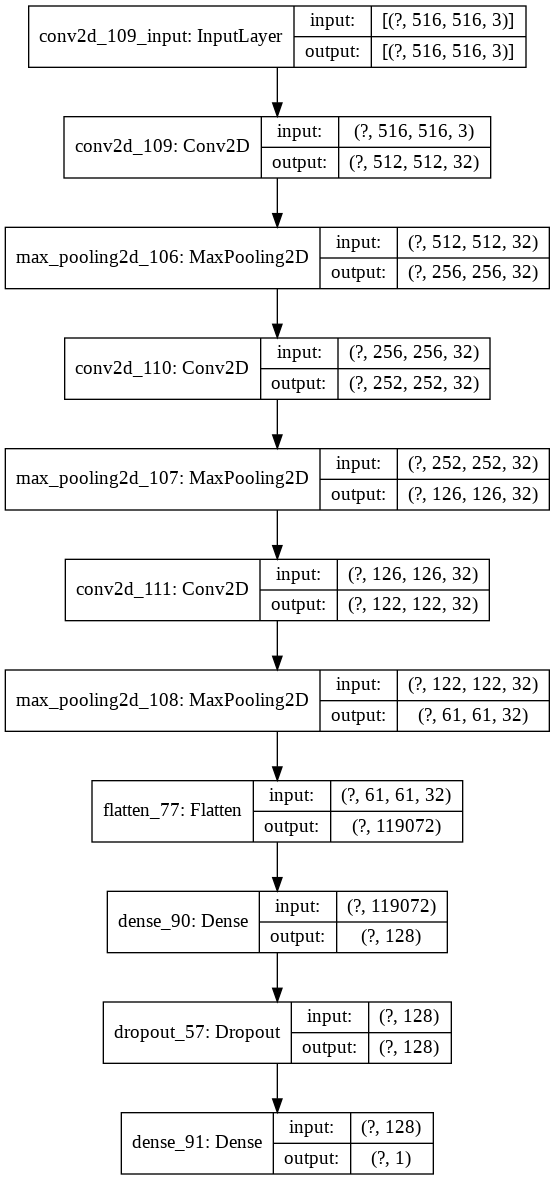

In [375]:
# Ahora consideraremos un modelo funcional para tener en cuenta la histología de los pacientes.
# Consideraremos la construcción de una CNN para las imágenes.

import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense, Dropout
from keras.models import Model, Sequential

model = Sequential()

model.add(Conv2D(32, kernel_size=5, activation='tanh', input_shape=(X_train1.shape[1],X_train1.shape[2],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Mostramos un esquema

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes = True)

In [376]:
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs=15)

Epoch 1/15
3/3 [==============================] - 1s 294ms/step - loss: 3.1529 - accuracy: 0.5341 - val_loss: 0.6767 - val_accuracy: 0.6136
Epoch 2/15
3/3 [==============================] - 1s 225ms/step - loss: 1.0329 - accuracy: 0.5682 - val_loss: 0.6687 - val_accuracy: 0.6136
Epoch 3/15
3/3 [==============================] - 1s 223ms/step - loss: 0.6704 - accuracy: 0.5341 - val_loss: 0.7831 - val_accuracy: 0.6136
Epoch 4/15
3/3 [==============================] - 1s 230ms/step - loss: 0.6013 - accuracy: 0.7386 - val_loss: 0.7947 - val_accuracy: 0.4773
Epoch 5/15
3/3 [==============================] - 1s 227ms/step - loss: 0.4021 - accuracy: 0.8295 - val_loss: 0.8445 - val_accuracy: 0.5227
Epoch 6/15
3/3 [==============================] - 1s 229ms/step - loss: 0.1462 - accuracy: 0.9773 - val_loss: 1.0086 - val_accuracy: 0.5909
Epoch 7/15
3/3 [==============================] - 1s 231ms/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 2.0849 - val_accuracy: 0.5909
Epoch 8/15
3/3 [====

In [377]:
xd = model.predict(X_test1)
y_pred = np.array([1 if xd[i] >= 0.5 else 0 for i in range(len(xd))])
print("Predicciones:\n", y_pred)
print("Reales:\n", y_test1)

from sklearn.metrics import confusion_matrix
from sklearn import metrics

tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test1, y_pred)
print("AUC de:", metrics.auc(fpr, tpr))
print("Accuracy de:", (tp+tn)/(tn+fp+fn+tp))
print("Recall de:", tp/(tp+fn))
print("Matriz de confusión:\n", confusion_matrix(y_test1, y_pred))

Predicciones:
 [1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0
 1 1 0 0 0 0 1]
Reales:
 [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1
 1 0 0 1 1 1 1]
AUC de: 0.5315904139433552
Accuracy de: 0.5454545454545454
Recall de: 0.47058823529411764
Matriz de confusión:
 [[16 11]
 [ 9  8]]


In [378]:
score = model.evaluate(X_test1,y_test1)
score

2/2 [==============================] - 0s 17ms/step - loss: 2.2617 - accuracy: 0.5455


[2.2617135047912598, 0.5454545617103577]

# Modelo Funcional donde se tiene en cuenta la histología.


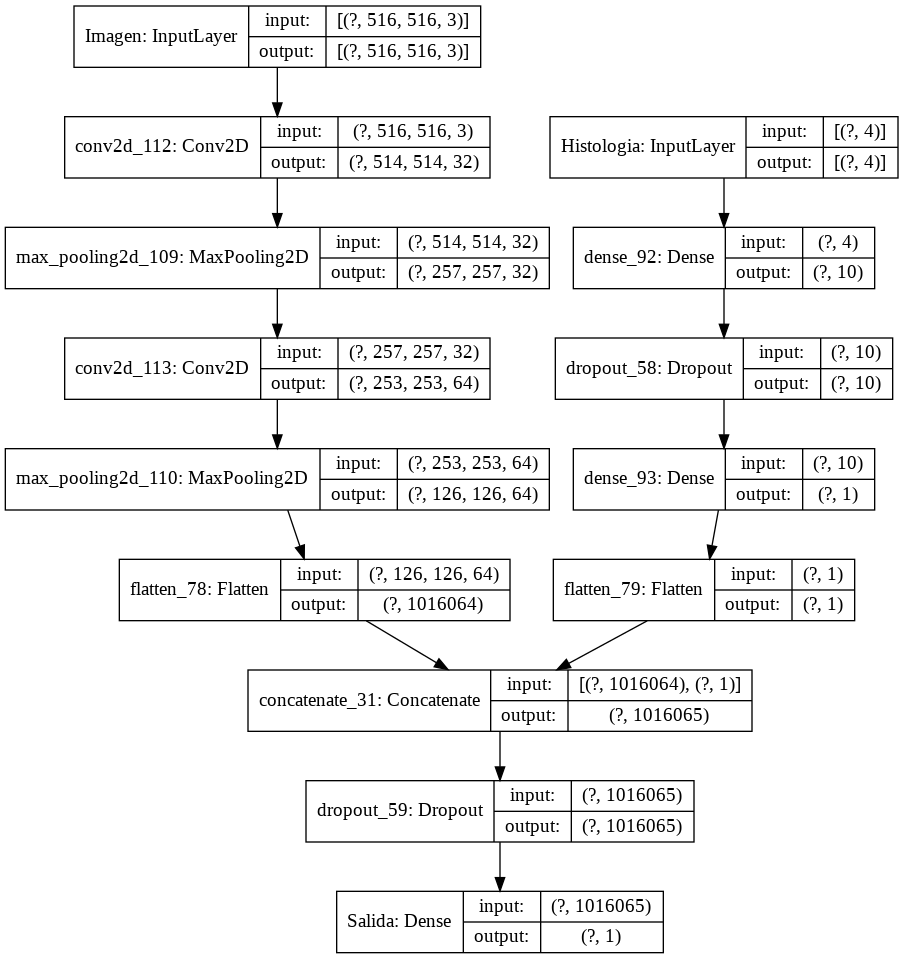

In [379]:
# Hemos de considerar también la histología para lo cual haremos un modelo funcional.

import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l1, l2

# Crearemos el modelo funcional.

# CNN para el input imagen:

imagen_input = Input(shape = (X_train1.shape[1], X_train1.shape[2],3), name = "Imagen")
conv1 = Conv2D(32, kernel_size=3, activation = "relu")(imagen_input)
maxpooling1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=5, activation = "tanh", activity_regularizer=l2(0.001))(maxpooling1)
maxpooling2 = MaxPooling2D(pool_size=(2, 2))(conv2)
salida_imagen = Flatten()(maxpooling2)

# MLP para el input categórico:

histologia_input = Input(shape=X_train2.shape[1], dtype = "int32", name = "Histologia")
densa1 = Dense(10, activation = "relu", activity_regularizer=l2(0.001))(histologia_input)
dropout1 = Dropout(0.6)(densa1)
densa2 = Dense(1, activation = "sigmoid")(dropout1)
salida_cat = Flatten()(densa2)

merged = keras.layers.concatenate([salida_imagen, salida_cat])
dropout2 = Dropout(0.3)(merged)
output = Dense(1, activation = "sigmoid", name = "Salida")(dropout2)

inception_module = Model(inputs = [imagen_input, histologia_input], outputs = output)

# Mostramos un esquema

from keras.utils.vis_utils import plot_model
plot_model(inception_module, show_shapes = True)

In [380]:
inception_module.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = inception_module.fit([X_train1, X_train2], y_train1, epochs=40, validation_data=([X_test1, X_test2], y_test1))

Epoch 1/40
3/3 [==============================] - 1s 366ms/step - loss: 14.1314 - accuracy: 0.4773 - val_loss: 5.1750 - val_accuracy: 0.5227
Epoch 2/40
3/3 [==============================] - 1s 280ms/step - loss: 6.3712 - accuracy: 0.4886 - val_loss: 6.1669 - val_accuracy: 0.3864
Epoch 3/40
3/3 [==============================] - 1s 282ms/step - loss: 4.0635 - accuracy: 0.5909 - val_loss: 2.1964 - val_accuracy: 0.4545
Epoch 4/40
3/3 [==============================] - 1s 285ms/step - loss: 1.8347 - accuracy: 0.6818 - val_loss: 2.3629 - val_accuracy: 0.4773
Epoch 5/40
3/3 [==============================] - 1s 284ms/step - loss: 1.3757 - accuracy: 0.8068 - val_loss: 1.7129 - val_accuracy: 0.5000
Epoch 6/40
3/3 [==============================] - 1s 283ms/step - loss: 1.1298 - accuracy: 0.8750 - val_loss: 2.0697 - val_accuracy: 0.3636
Epoch 7/40
3/3 [==============================] - 1s 283ms/step - loss: 0.9889 - accuracy: 0.8864 - val_loss: 1.3342 - val_accuracy: 0.5455
Epoch 8/40
3/3 [===

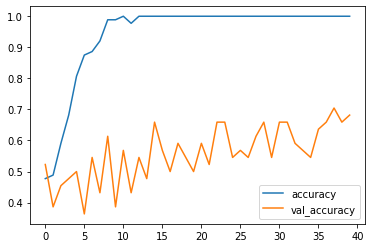

In [381]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure
plt.plot(inception_module.history.history['accuracy'],label="accuracy")
plt.plot(inception_module.history.history['val_accuracy'],label="val_accuracy")
plt.legend()
plt.show()

In [382]:
xd = inception_module.predict([X_test1, X_test2])
y_pred = np.array([1 if xd[i] >= 0.5 else 0 for i in range(len(xd))])
print("Predicciones:\n", y_pred)
print("Reales:\n", y_test1)

from sklearn.metrics import confusion_matrix
from sklearn import metrics

tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test1, y_pred)
print("AUC de:", metrics.auc(fpr, tpr))
print("Accuracy de:", (tp+tn)/(tn+fp+fn+tp))
print("Recall de:", tp/(tp+fn))
print("Matriz de confusión:\n", confusion_matrix(y_test1, y_pred))

Predicciones:
 [0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0
 0 1 0 1 0 1 1]
Reales:
 [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1
 1 0 0 1 1 1 1]
AUC de: 0.664488017429194
Accuracy de: 0.6818181818181818
Recall de: 0.5882352941176471
Matriz de confusión:
 [[20  7]
 [ 7 10]]


In [383]:
# Guardaré los pesos en h5

# serialize model to JSON
model_json = inception_module.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("bestmodelfuncional1.h5")
print("Saved model to disk")

# Para cargarlos haríamos:

#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
#loaded_model.load_weights("bestmodelfuncional1.h5")
#print("Loaded model from disk")

Saved model to disk


In [384]:
import h5py

hf = h5py.File("data_augmented_bestmodel.h5", "w")
hf.create_dataset("new_data_augmented", data = new_data_augmented)
hf.create_dataset("labels", data = labels)
hf.create_dataset("histologia", data = histologia)
hf.close()